# **Analyse de sentiments sur les critiques spectateurs sur Allociné**
**Projet Python pour la Data science - 2A ENSAE**

Zakaria BOULLIAIRE, Massyle DENDENE, Brian RAMESH

# Introduction

L'idée de ce projet est de prédire ("mettre la variable à prédire"), à partir d'une analyse de sentiment faite sur les critiques données pas les spectateurs (et non la presse), sur le site Allociné. 
Nous allons donc consituer une base de données de film, en scrappant le site Allociné et en utilisant l'API de The Movie Database (TMDB) pour compléter les données manquantes.

### Imports nécessaires

In [1]:
# BeutifulSoup pour le scrapping
from urllib.request import urlopen
from bs4 import BeautifulSoup as bs
import requests
from concurrent.futures import ThreadPoolExecutor


In [2]:
# Classique python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import seaborn as sns
from warnings import warn
from time import sleep
from datetime import datetime
from dateutil import parser 

In [8]:
# NLP
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import string

from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer

In [10]:
# ML

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection, preprocessing, naive_bayes, metrics
from sklearn import decomposition, ensemble

# Collecte des données

### Scrapping sur Allociné

Tout d'abord, nous allons restreindre notre base de données aux films américains des années 2010 à 2021. Cela constiuerait une base de données de 11 822 films (avant nettoyage)

Les données qui peuvent nous être utiles sont les suivantes : Titre original du film, identifiant du film sur Allociné (qui nous sera utile pour récupérer les critiques plus tard), la note des spectateurs et celle de la presse, le nombre de critiques presse, le nombre de critiques spectateurs et le nombre de votes pour la notes (dans une seule et même variable, qu'on spérera lors du nettoyage), la date de sortie du film, le budget et le Box Office US. 
Nous avions également commencer à scrapper le N°Visa du film, qui est unique pour chaque film, en vue d'utiliser cette donnée pour la collecte sur TMDB, mais il y avait énormément de film pour lesquels cette donnée manquait. Nous avons décider de ne pas l'utiliser.

L'idée de la fonction ci dessous est de scrapper les données dont on a besoin à partir de l'url et du nombre de page.

In [4]:
# Role : Scraping des pages de film sur le site allocine.fr
# Entrée : url et nombre de de page
# Sortie : un dataframe contenant toutes les données scrapées
 
def scraping_film_allocine(base_url, nb_page):

    # Liste ou on stock nos données
    data = []
    
    # Variable de comptage pour voir l'évolution du scrapping, et détecter les eventuelles erreurs
    i=0

    # Boucle sur les pages
    for page in range(1, nb_page+1): 
        url_page_ac = f"{base_url}{page}"

        response_page_ac = requests.get(url_page_ac)

        if response_page_ac.status_code == 200:
            bs_page_ac = bs(response_page_ac.text, "html.parser")
            films_page_ac = bs_page_ac.findAll("li", attrs={'class': "mdl"})

            for film_allocine in films_page_ac:
                i+=1
                try:
                    
                    # Id du film sur allo cine
                    meta_title_link = film_allocine.find('a', class_='meta-title-link')

                    if meta_title_link:
                        href1 = meta_title_link.get('href')
                        film_id = href1.split('=')[-1].split('.')[0]
                    else:
                        film_id = None


                    # Scrapping de la page fiche info du film qu'on obtient grace à l'id trouvé ci dessus
                    url_fiche_film = f'https://www.allocine.fr/film/fichefilm_gen_cfilm={film_id}.html'
                    response_fiche_film = requests.get(url_fiche_film)
                    bs_fiche_film = bs(response_fiche_film.text, "html.parser")

                    # Titre
                    titre_allocine = meta_title_link.text

                    span_titre_original = bs_fiche_film.find('span', class_='light', string='Titre original ')
                    titre_original = span_titre_original.find_next_sibling(string=True).strip() if span_titre_original else titre_allocine


                    # Notes spectateurs/presse, nombre critiques presse/spectateurs
                    bloc_notes = bs_fiche_film.findAll('span', class_='stareval-note')
                    list_notes = [notes.get_text(strip=True) for notes in bloc_notes]

                    if len(list_notes)==0:
                        note_presse = None
                        note_spectateur = None
                        
                    else:
                        index_delimiteur = list_notes.index('--')
                        new_liste_notes = list_notes[:index_delimiteur]

                        if len(new_liste_notes)==2:
                            note_presse = new_liste_notes[0]
                            note_spectateur = new_liste_notes[1]
                        
                        elif len(new_liste_notes) > 0 and len(new_liste_notes) <= 1:
                            note_spectateur = new_liste_notes[0]
                            note_presse = None

                    bloc_critiques = bs_fiche_film.find_all('span', class_='stareval-review')

                    if len(bloc_critiques)==2:
                        critiques_element_presse = bloc_critiques[0].text
                        critiques_element_spec = bloc_critiques[1].text
                    elif len(bloc_critiques) > 0 and len(bloc_critiques) <= 1:
                        critiques_element_spec = bloc_critiques[0].text
                        critiques_element_presse = None
                    else:
                        critiques_element_presse = None
                        critiques_element_spec = None


                    #Date, durée, budget
                    date_film_element = film_allocine.find('span', class_='date')
                    date_film = date_film_element.text if date_film_element else None

                    duree_film_element = bs_fiche_film.find('span', class_='spacer')
                    duree_film = duree_film_element.next_sibling.strip() if duree_film_element else None

                    budget_element = bs_fiche_film.find('span', class_='what light', string='Budget')
                    budget_film = budget_element.find_next('span').string if budget_element else None

                    #visa_element = bs_fiche_film.find('span', class_='what light', string='N° de Visa')
                    #visa_film = visa_element.find_next('span').string if visa_element else None

                    # Box office
                    url_box_office = f'https://www.allocine.fr/film/fichefilm-{film_id}/box-office/'
                    response_box_office = requests.get(url_box_office)
                    bs_box_office = bs(response_box_office.text, "html.parser")

                    cumul = bs_box_office.findAll('td', {'data-heading': 'Cumul'})
                    list_cumul = [cum.get_text(strip=True) for cum in cumul]

                    box_office_film = list_cumul[-1] if list_cumul else 'None'

                    data.append([titre_original, note_presse, note_spectateur, critiques_element_presse, critiques_element_spec, film_id, box_office_film, budget_film,
                                date_film, duree_film])
                    
                    df_data = pd.DataFrame(data, columns=["Titre original", "Note press", "Notes spectateur", "Critiques presse", "Critiques spectateurs", 'id allocine',
                                          'Box office', 'Budget', 'date', 'duree'])


                    print(i)
                except Exception as e:
                    print(f"Une erreur s'est produite pour le film {i} : {e}")

    return df_data

CPU times: user 4 µs, sys: 5 µs, total: 9 µs
Wall time: 13.8 µs


In [ ]:
%%time

# Urls qu'on veut scrapper
base_url_2010_2020, nb_page_2010_2020 = 'https://www.allocine.fr/films/pays-5002/decennie-2010/?page=', 646
base_url_2020, nb_page_2020 = 'https://www.allocine.fr/films/pays-5002/decennie-2020/annee-2020/?page', 66
base_url_2021, nb_page_2021 = 'https://www.allocine.fr/films/pays-5002/decennie-2020/annee-2021/?page', 77

# Application de la fonction scrapping_film_allocine
df_data_2010_2020 = scraping_film_allocine(base_url_2010_2020, nb_page_2010_2020)
df_data_2020 = scraping_film_allocine(base_url_2020, nb_page_2020)
df_data_2021 = scraping_film_allocine(base_url_2021, nb_page_2021)

In [ ]:
# Créer un DataFrame avec les données collectées
dfs=[df_data_2010_2020, df_data_2020, df_data_2021]

df_film_ac = pd.concat(dfs, ignore_index=True)

In [ ]:
df_film_ac.to_csv('df_film_ac.csv', index=False) ### DF important

### Nettoyage de la base obtenue sur Allociné

In [19]:
df_film_ac= pd.read_csv("df_film_ac.csv")

In [20]:
df_film_ac 

,Titre original,Note press,Notes spectateur,Critiques presse,Critiques spectateurs,id allocine,Box office,Budget,date,duree
0,Shutter Island,"3,8","4,4",31 critiques,80471 notes dont 4605 critiques,132039,127 770 000,80 000 000 $,24 février 2010,2h 17min
1,Inception,"4,1","4,5",24 critiques,110095 notes dont 7212 critiques,143692,290 948 208,160 000 000 $,21 juillet 2010,2h 28min
2,Harry Potter and the Deathly Hallows - Part 1,"3,2","4,0",20 critiques,52676 notes dont 2887 critiques,126693,291 377 000,150 000 000 $,24 novembre 2010,2h 26min
3,Prince of Persia: The Sands of Time,"2,6","3,1",22 critiques,26730 notes dont 2133 critiques,126678,89 981 000,200 000 000 $,26 mai 2010,2h 06min
4,The Book of Eli,"2,4","3,3",20 critiques,10503 notes dont 1144 critiques,128955,92 524 000,80 000 000 $,20 janvier 2010,1h 49min
...,...,...,...,...,...,...,...,...,...,...
11816,Amarillo,NaN,NaN,NaN,NaN,294872,NaN,-,NaN,NaN
11817,Chastise,NaN,NaN,NaN,NaN,295695,NaN,-,NaN,NaN
11818,Tapawingo,NaN,NaN,NaN,NaN,296176,NaN,-,NaN,NaN
11819,Mr. Birthday,NaN,NaN,NaN,NaN,298844,NaN,-,NaN,NaN


Comme on peut voir, la base a besoin d'être nettoyé. Nous allons extraires le nombre de critiques de la presse, le nombre de notes sepcteurs et le nombre de critiques des spectateurs. Nous allons convertir également le format de la date, et la durée du film en minute.

Puis, nous allons supprimer tous les films qui n'ont pas de note spectateurs et/ou qui ont moins de 5 critiques

In [21]:
print(df_film_ac.dtypes)

Titre original           object
Note press               object
Notes spectateur         object
Critiques presse         object
Critiques spectateurs    object
id allocine               int64
Box office               object
Budget                   object
date                     object
duree                    object
dtype: object


In [22]:
# Modifications des types 

df_film_ac['Box office'] = df_film_ac['Box office'].str.replace(' ', '').astype(float)
df_film_ac['Note press'] = df_film_ac['Note press'].str.replace(',', '.').astype(float)
df_film_ac['Notes spectateur'] = df_film_ac['Notes spectateur'].replace("--", np.nan)
df_film_ac['Notes spectateur'] = df_film_ac['Notes spectateur'].str.replace(',', '.').astype(float)

In [23]:
print(df_film_ac.dtypes)

Titre original            object
Note press               float64
Notes spectateur         float64
Critiques presse          object
Critiques spectateurs     object
id allocine                int64
Box office               float64
Budget                    object
date                      object
duree                     object
dtype: object


In [9]:
# Role : Convertir les mois scrapés en français en anglais
# Entrée : mois en français
# Sortie : mois en anglais

def french_to_english_month(month_french):
    months_mapping = {
        'janvier': 'January',
        'février': 'February',
        'mars': 'March',
        'avril': 'April',
        'mai': 'May',
        'juin': 'June',
        'juillet': 'July',
        'août': 'August',
        'septembre': 'September',
        'octobre': 'October',
        'novembre': 'November',
        'décembre': 'December'
    }
    return months_mapping.get(month_french.lower(), month_french)



# Role : Convertir une durée en heure en une durée en minute
# Entrée : durée en heure
# Sortie : durée en minute

def convert_duration(duration_str):
    if isinstance(duration_str, str):
        # Supprimer les espaces et diviser la chaîne en parties
        parts = duration_str.replace(' ', '').split('h')

        # Vérifier la présence des heures et des minutes
        if len(parts) == 2:
            hours = int(parts[0])
            minutes = 0 if 'min' not in parts[1] else int(parts[1].replace('min', ''))
            
            # Calculer la durée totale en minutes
            total_minutes = hours * 60 + minutes
            
            return int(total_minutes)
    
    # Gérer le cas où la valeur est déjà un nombre ou ne peut pas être convertie
    return float('nan')



# Role : Extraire le nombre de critique de la presse
# Entrée : "21 critiques"
# Sortie : Nombre de critique de la presse

def extract_critiques_count(critiques_str):
    if isinstance(critiques_str, str):
        # Utiliser isdigit() pour extraire uniquement les chiffres
        return np.nan if not critiques_str.split()[0].isdigit() else int(critiques_str.split()[0])
    else:
        return np.nan



# Role : Extraire le nombre de notes et le nombre de critiques (spectateurs)
# Entrée : "80471 notes dont 4605 critiques"
# Sortie : Nombre de notes spectatuers et nombre de critiques spectateurs

def extract_notes_and_critiques_count(critiques_str):
    if isinstance(critiques_str, str):
        # Trouver les nombres dans la chaîne
        numbers = [int(word) for word in critiques_str.split() if word.isdigit()]

        # Extraire le nombre de notes et de critiques en fonction de la longueur de la liste "numbers"
        if len(numbers) == 1:
            return numbers[0], np.nan
        elif len(numbers) == 2:
            return numbers[0], numbers[1]

    # Gérer le cas où la valeur est déjà un nombre ou ne peut pas être convertie
    return np.nan, np.nan

Appliquons une série de fonction au datframe, pour plusieurs convertions, normalisations et extractions de données.

In [25]:
# Remplacer les chaînes "nan" par des valeurs NaN
df_film_ac['date'] = df_film_ac['date'].replace('nan', np.nan)

# Appliquer la fonction pour convertir le mois en anglais
df_film_ac['date'] = df_film_ac['date'].apply(lambda x: ' '.join([french_to_english_month(word) for word in str(x).split()]) if pd.notna(x) else np.nan)

# Utiliser dateutil.parser.parse pour convertir les dates en objets datetime
df_film_ac['date'] = df_film_ac['date'].apply(lambda x: parser.parse(x, dayfirst=True) if isinstance(x, str) else x)

# Appliquer la fonction de conversion pour la durée
df_film_ac['duree_minutes'] = df_film_ac['duree'].apply(convert_duration)

# Appliquer la fonction extract_notes_and_critiques_count
df_film_ac[['Nombre_de_notes_spectateurs', 'Nombre_de_critiques_spectateurs']] = df_film_ac['Critiques spectateurs'].apply(extract_notes_and_critiques_count).apply(pd.Series)

# Appliquer la fonction extract_critiques_count
df_film_ac['Nombre_de_critiques_presse'] = df_film_ac['Critiques presse'].apply(extract_critiques_count)

In [27]:
# Retrait des colonnes inutiles 
colonnes_a_retirer = ["Critiques presse","Critiques spectateurs","duree","Budget"]
df_film_ac = df_film_ac.drop(colonnes_a_retirer,axis=1)

In [29]:
# Retrait de tous les films sans critique spectateurs
# On garde que les films avec au moins plus de 5 commentaires

df_film_ac_clean = df_film_ac.dropna(subset=['Nombre_de_critiques_spectateurs'])
df_film_ac_clean = df_film_ac_clean[df_film_ac_clean['Nombre_de_critiques_spectateurs'] >= 5]

In [30]:
# Extraire le jour, le mois et l'année dans des colonnes distinctes
df_film_ac_clean['mois_sortie'] = df_film_ac_clean['date'].dt.month
df_film_ac_clean['annee_sortie'] = df_film_ac_clean['date'].dt.year

In [32]:
df_film_ac_clean.to_csv('df_film_ac_clean.csv', index=False)

### Scrapping des données sur TMDB

Le scrapping des données sur TMDB nécessite l'utilisation de l'API du site. Pour se faire, il a fallu créer une clé :

In [ ]:
key_api='d1d1413d8379729633d60e9f5cc4a730'

In [ ]:
## Fonctions

# Fonction pour récupérer l'id du film (à partir du titre du film issu de la base scrappé sur allociné)
def id_recup(titre):
    url_api=f"https://api.themoviedb.org/3/search/movie?api_key={key_api}&query={titre}" 
    req = requests.get(url_api)
    carte = req.json()

    ind=[]
    for film in range(len(carte['results'])):
        ind.append(carte['results'][film]['id'])
    return(ind)


# Fonction pour récuperer les infos du film à partir de l'id (prend en entrée l'id du film sur tmdb et renvoie un dataframe)
def df_avec_id(id):
    id_film= id
    url_new_api = f"https://api.themoviedb.org/3/movie/{id_film}?api_key={key_api}&language=en-US"
    req_new = requests.get(url_new_api)
    wb_new = req_new.json()
    
    
    #ajustement des données 
    if 'belongs_to_collection' in wb_new and wb_new['belongs_to_collection'] is not None:
        wb_new['belongs_to_collection'] = wb_new['belongs_to_collection']['name']

        
    # Ajustement des données pour la clé 'genres'
    if 'genres' in wb_new:
        wb_new['genres'] = ', '.join([x['name'] for x in wb_new['genres']])
    else:
        wb_new['genres'] = None

# Ajustement des données pour la clé 'production_companies'
    if 'production_companies' in wb_new:
        wb_new['production_companies'] = ', '.join([x['name'] for x in wb_new['production_companies']])
    else:
        wb_new['production_companies'] = None

# Ajustement des données pour la clé 'production_countries'
    if 'production_countries' in wb_new:
        wb_new['production_countries'] = ', '.join([x['name'] for x in wb_new['production_countries']])
    else:
        wb_new['production_countries'] = None

# Ajustement des données pour la clé 'spoken_languages'
    if 'spoken_languages' in wb_new:
        wb_new['spoken_languages'] = ', '.join([x['name'] for x in wb_new['spoken_languages']])
    else:
        wb_new['spoken_languages'] = None

    
    df=pd.DataFrame(wb_new, index=[0])
    
    return (df)


def get_movie_info(movie_id_list):
# Initialiser un DataFrame vide pour stocker les informations sur les films
    movie_df = pd.DataFrame()

    for movie_id in movie_id_list:
        # Utiliser la deuxième fonction pour obtenir les informations détaillées du film
        movie_info = df_avec_id(movie_id)

        # Vérifier si des informations ont été trouvées
        if movie_info is not None:
            # Ajouter les informations du film au DataFrame
            movie_df = pd.concat([movie_df, movie_info], ignore_index=True)

    return movie_df


def create_movie_list(movie_list):
    all_movies_df = pd.DataFrame()

    for movie_name in movie_list:
        movie_id_list = id_recup(movie_name)
        if movie_id_list:
            movie_info_df = get_movie_info(movie_id_list)
            # Ajouter les informations du film au DataFrame global
            all_movies_df = pd.concat([all_movies_df, movie_info_df], ignore_index=True)

    return all_movies_df



# Fonction qui prend en entrée une liste et qui renvoie 4 sous-liste de taille identique (à une division entière près) 
def diviser_liste(liste):
    taille = len(liste)
    quart = taille // 4
    partie1 = liste[:quart]
    partie2 = liste[quart:2*quart]
    partie3 = liste[2*quart:3*quart]
    partie4 = liste[3*quart:]
    return partie1, partie2, partie3, partie4

On récupère ensuite les films de la base d'Allociné nettoyé précédemment.

In [33]:
df_film_ac_clean= pd.read_csv("df_film_ac_clean.csv")
liste_films_ac = df_film_ac_clean['Titre original'].tolist()

len(liste_films_ac)

4194

On va séparer notre dataframe en 4 en vue de la récolte des données à l'aide de l'API de TMDB. En effet, on rencontrait une erreur liée aux nombres de requêtes lorsqu'on utilisait le data frame en entier (ou même si on le séparait en 2)

In [34]:
liste_films_ac_1, liste_films_ac_2, liste_films_ac_3, liste_films_ac_4 = diviser_liste(liste_films_ac)


# Affichage des quatres listes résultantes
print("Partie 1:", len(liste_films_ac_1))
print("Partie 2:", len(liste_films_ac_2))
print("Partie 3:", len(liste_films_ac_3))
print("Partie 4:", len(liste_films_ac_4))

Partie 1: 1048
Partie 2: 1048
Partie 3: 1048
Partie 4: 1050


In [ ]:
%%time 
df_film_ac_clean_1 = create_movie_list(liste_films_ac_1)


# CPU times: user 3min 37s, sys: 17.1 s, total: 3min 54s
# Wall time: 21min 6s

In [ ]:
%%time
df_film_ac_clean_2 = create_movie_list(liste_films_ac_2)

# CPU times: user 3min 54s, sys: 20.2 s, total: 4min 14s
# Wall time: 21min 41s

In [ ]:
%%time
df_film_ac_clean_3 = create_movie_list(liste_films_ac_3)

# CPU times: user 3min 52s, sys: 19.9 s, total: 4min 12s
# Wall time: 20min 36s

In [ ]:
%%time
df_film_ac_clean_4 = create_movie_list(liste_films_ac_4)

# CPU times: user 3min 43s, sys: 19.5 s, total: 4min 04s
# Wall time: 20min 56s

In [ ]:
# Rassembler les DataFrames en un seul DataFrame
dataframes = [df_film_ac_clean_1, df_film_ac_clean_2, df_film_ac_clean_3, df_film_ac_clean_4]

df_tmdb = pd.concat(dataframes, ignore_index=True)

In [ ]:
# Sauvegarder le DataFrame tmdb en CSV
df_tmdb.to_csv('df_tmdb.csv', index=False)

# Afficher le DataFrame final
df_tmdb.head()

## Nettoyage de la base TMDB

In [38]:
df_tmdb= pd.read_csv("df_tmdb.csv", engine="python")

In [39]:
noms_variables = df_tmdb.columns.tolist()

for i in noms_variables:
    print(i,":",df_tmdb[i].isnull().sum())

adult : 6
backdrop_path : 15053
belongs_to_collection : 30493
budget : 181
genres : 5489
homepage : 26420
id : 161
imdb_id : 7521
original_language : 181
original_title : 161
overview : 1692
popularity : 187
poster_path : 4893
production_companies : 11739
production_countries : 8237
release_date : 2024
revenue : 213
runtime : 213
spoken_languages : 7419
status : 213
tagline : 22747
title : 213
video : 213
vote_average : 213
vote_count : 213
success : 34373
status_code : 34373
status_message : 34373


On observe que les trois dernières colonnes peuvent être supprimés de la dataframe car trop de valeurs manquantes


In [ ]:
colonnes_a_supprimer = ["success", "status_code", "status_message"]
df_tmdb_clean = df_tmdb.drop(columns=colonnes_a_supprimer)

In [40]:
# Changement format release date 

df_tmdb_clean['release_date'] = pd.to_datetime(df_tmdb['release_date'], errors="coerce")
df_tmdb_clean["release_date"].value_counts()

release_date
2009-01-01    75
2011-01-01    71
2008-01-01    70
2014-01-01    68
2007-01-01    68
              ..
2021-08-21     1
1998-06-09     1
1950-05-19     1
1980-03-28     1
1983-09-16     1
Name: count, Length: 12586, dtype: int64

In [41]:
# Extraire le jour, le mois et l'année dans des colonnes distinctes
df_tmdb_clean['mois_sortie'] = df_tmdb_clean['release_date'].dt.month
df_tmdb_clean['annee_sortie'] = df_tmdb_clean['release_date'].dt.year

### Merge de la base Allociné et de la base TMDB

Nous allons procéder au merge des deux bases.

On commence par normalisé les titres en les mettant en minuscule, et en retirant les espace

In [36]:
df_film_ac_clean= pd.read_csv("df_film_ac_clean.csv", engine="python")


In [42]:
df_film_ac_clean['titre_normalise'] = df_film_ac_clean['Titre original'].str.replace(r'\W', '', regex=True).str.lower()
df_tmdb_clean['titre_normalise'] = df_tmdb_clean['original_title'].str.replace(r'\W', '', regex=True).str.lower()

On commence par prendre les elements qui se ressemblent dans les deux listes.

In [43]:
liste_titre_ac = df_film_ac_clean["titre_normalise"].tolist()
liste_titre_tmdb = df_tmdb_clean["titre_normalise"].tolist()

In [46]:
liste_ressemblance = [element for element in liste_titre_tmdb if element in liste_titre_ac]

On remarque à ce niveau que certains films apparaissent plusieurs fois dans liste_ressemblance du fait que de nombreux films sont sortis sous le meme nom 

In [47]:
# On commence par garder dans la base df_tmdb_clean que les films qui sont dans liste_ressemblance
df_filtre_tmdb = df_tmdb_clean[df_tmdb_clean['titre_normalise'].isin(liste_ressemblance)]


# On trie ensuite la base par ordre alphabetique des films et decroissants des dates
df_filtre_tmdb_trie = df_filtre_tmdb.sort_values(by=['titre_normalise', 'release_date'], ascending=[True, False])
df_filtre_tmdb_trie = df_filtre_tmdb_trie.reset_index(drop=True)

# Conservation des films sorties entre 2010 et 2021 (et valeurs manquantes aussi)
df_filtre_tmdb_trie = df_filtre_tmdb_trie[(df_filtre_tmdb_trie['annee_sortie'] >= 2010) & (df_filtre_tmdb_trie['annee_sortie'] <= 2021) | df_filtre_tmdb_trie['annee_sortie'].isna()]
df_filtre_tmdb_trie = df_filtre_tmdb_trie.reset_index(drop=True)

# On retire tous les doublons parfaits de la base 
df_filtre_tmdb_trie = df_filtre_tmdb_trie.drop_duplicates(keep='first')
df_filtre_tmdb_trie = df_filtre_tmdb_trie.reset_index(drop=True)

df_filtre_tmdb_trie.to_csv("df_tmdb_tri.csv", index=False)

Pour merge les deux bases, nous allons utiliser le nom du réalisateur comme clé primaire. En efft, étant donné, qu'il y a plusieurs fois le même titre sur la base de TMDB, il nous a fallu trouver une autre solution.

In [53]:
# On recupere les id des films sur la base TMDB pour recuperer le nom des realisateur de chaque film
liste_id = df_filtre_tmdb_trie["id"].tolist()
liste_id_entiers = [int(nombre) for nombre in liste_id]
len(liste_id_entiers)

7312

In [ ]:
%%time

def get_directors_for_movies(movie_ids, api_key):
    directors_dict = {}

    for movie_id in movie_ids:
        # Envoyer une requête GET à l'API TMDb pour obtenir les crédits du film
        response = requests.get(f'https://api.themoviedb.org/3/movie/{movie_id}/credits?api_key={api_key}')

        # Vérifier si la requête a réussi (code 200)
        if response.status_code == 200:
            # Extraire le contenu JSON de la réponse
            json_data = response.json()

            # Filtrer la liste des membres de l'équipe pour ne conserver que les réalisateurs
            directors = [member.get('name') for member in json_data.get('crew', []) if member.get('job') == 'Director']

            # Ajouter l'association identifiant-réalisateur au dictionnaire
            directors_dict[movie_id] = directors if directors else None
        else:
            # En cas d'échec de la requête, ajouter une valeur manquante au dictionnaire
            directors_dict[movie_id] = None

    return directors_dict

In [ ]:
api_key = "d1d1413d8379729633d60e9f5cc4a730"

# Appeler la fonction pour obtenir le dictionnaire des réalisateurs
directors_result = get_directors_for_movies(liste_id_entiers, api_key)

In [ ]:
# Ajouter une colonne 'nom_du_realisateur' en utilisant le dictionnaire
df_filtre_tmdb_trie['nom_du_realisateur'] = df_filtre_tmdb_trie['id'].map(directors_result)

# Afficher le DataFrame résultant
df_filtre_tmdb_trie.head()
df_filtre_tmdb_trie.to_csv("df_filtre_trie.csv", index=False)

On récupère ensuite le nom des réalisateurs sur Allociné

In [54]:
%%time

def get_director_name(url):
    # Envoyer une requête GET à l'URL de la page Allociné
    response = requests.get(url)

    # Vérifier si la requête a réussi (code 200)
    if response.status_code == 200:
        # Extraire le contenu HTML de la réponse
        html_content = response.content

        # Utiliser BeautifulSoup pour parcourir le HTML
        soup = BeautifulSoup(html_content, 'html.parser')

        # Trouver la balise contenant le nom du réalisateur
        director_tag = soup.find('div', class_='meta-body-direction')

        # Extraire le texte entre les balises
        director_name = director_tag.text.strip() if director_tag else None

        return director_name

    else:
        # En cas d'échec de la requête, retourner une valeur manquante
        return None

def get_director_names_from_urls(identifiants):
    director_names = {}

    for identifiant in identifiants:
        # Construire l'URL à partir de l'identifiant
        url = f'https://www.allocine.fr/film/fichefilm_gen_cfilm={identifiant}.html'

        # Appeler la fonction pour obtenir le nom du réalisateur
        nom_realisateur = get_director_name(url)

        # Ajouter le nom du réalisateur au dictionnaire
        director_names[identifiant] = nom_realisateur

    return director_names


CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 11.7 µs


In [ ]:
liste_identifiants = df_film_ac_clean["id allocine"].tolist()

resultat = get_director_names_from_urls(liste_identifiants)

# Afficher le résultat
#for identifiant, nom_realisateur in resultat.items():
    #print(f"Film {identifiant}: Réalisateur {nom_realisateur}")

print(len(resultat))
print(resultat)

In [ ]:
# Ajouter une colonne 'nom_du_realisateur' en utilisant le dictionnaire
df_film_ac_clean['nom_du_realisateur'] = df_film_ac_clean['id allocine'].map(resultat)

# Afficher le DataFrame résultant
df_film_ac_clean.head()
df_film_ac_clean.to_csv("df_film_ac_clean.csv", index=False)

In [ ]:
df_film_ac_clean['nom_du_realisateur'] = df_film_ac_clean['nom_du_realisateur'].str.replace('De\n', '')

In [ ]:
#ne pas mettre dans la meme cellule qu'avant

df_film_ac_clean['nom_du_realisateur'] = df_film_ac_clean['nom_du_realisateur'].str.replace('\n', '')

In [ ]:
df_filtre_tmdb_trie['nom_du_realisateur'] = df_filtre_tmdb_trie['nom_du_realisateur'].apply(lambda x: x[0] if x else None)

In [55]:
# Prend en entrée un string et renvoie le même string sans les accents

def remove_accents(input_str):
    accents = {
        'a': '[aáàâäãå]',
        'e': '[eéèêë]',
        'i': '[iíìîï]',
        'o': '[oóòôöõ]',
        'u': '[uúùûü]',
        'c': '[cç]',
        'n': '[nñ]'
    }
    for char, pattern in accents.items():
        input_str = re.sub(pattern, char, input_str)
    return input_str

In [ ]:
# Appliquer la fonction remove_accents à la colonne nom_du_realisateur

df_filtre_tmdb_trie['nom_du_realisateur_bis'] = df_filtre_tmdb_trie['nom_du_realisateur'].apply(lambda x: remove_accents(x) if pd.notnull(x) else x)
df_film_ac_clean['nom_du_realisateur_bis'] = df_film_ac_clean['nom_du_realisateur'].apply(lambda x: remove_accents(x) if pd.notnull(x) else x)

In [ ]:
# Nnormalisation 

df_film_ac_clean['nom_du_realisateur_bis'] = df_film_ac_clean['nom_du_realisateur_bis'].str.replace(r'\W', '', regex=True).str.lower()
df_filtre_tmdb_trie['nom_du_realisateur_bis'] = df_filtre_tmdb_trie['nom_du_realisateur_bis'].str.replace(r'\W', '', regex=True).str.lower()

In [ ]:
df_film_ac_clean = df_film_ac_clean.sort_values(by=['titre_normalise', 'date'], ascending=[True, False])
df_film_ac_clean = df_film_ac_clean.reset_index(drop=True)

In [ ]:
# Conserve uniquement les correspondances
df_merged = pd.merge(df_film_ac_clean, df_filtre_tmdb_trie, left_on=['titre_normalise', 'nom_du_realisateur_bis'], right_on=['titre_normalise', 'nom_du_realisateur_bis'])
print(len(df_merged))

df_merged.to_csv("df_merged.csv", index=False)

#conserve les correspondances et tout du cote df_film_avec_critiques
#df_merged_bis= pd.merge(df_film_avec_critiques, df_filtre_trie, on=['titre_normalise', 'nom_du_realisateur_bis'], how='left')
#df_merged_bis.to_csv("df_merged_bis.csv", index=False)


### Scrapping des critiques sur Allocine

Maintenant que nous avons notre base finale, avec toutes les données, on peut faire le scrapping des critiques spectateurs sur Allociné grâce à l'id du film.

In [2]:
df_final_ac = pd.read_csv('df_merged.csv')
df_final_ac = df_final_ac.drop_duplicates(subset='id allocine', keep='first')

In [3]:
df_final_ac['Nombre_de_critiques_spectateurs'] = df_final_ac['Nombre_de_critiques_spectateurs'].astype(int)
#df_final_ac = df_final_ac.sort_values(by='Nombre_de_critiques_spectateurs', ascending=False)

somme_critique = df_final_ac['Nombre_de_critiques_spectateurs'].sum()

liste_id = df_final_ac['id allocine'].tolist()
nb_critique = df_final_ac['Nombre_de_critiques_spectateurs'].tolist()


# Créez un dictionnaire à partir des couples
couple_listes = zip(liste_id, nb_critique)
dico_id_critique = dict(couple_listes)

print(somme_critique)

784779


In [4]:
# Role : Découper un dictionnaire en parties égales
# Entrée : dictionnaire et un facteur
# Sortie : liste avec le dictionnaire découpé en ce nombre de facteur

def divide_dict(dictionary, div):
    if not isinstance(dictionary, dict):
        raise ValueError("Le paramètre doit être un dictionnaire.")

    dict_items = list(dictionary.items())
    total_items = len(dict_items)

    if total_items % div != 0:
        raise ValueError("Le dictionnaire ne peut pas être divisé en 8 parties égales.")

    chunk_size = total_items // div
    divided_dicts = [dict_items[i:i + chunk_size] for i in range(0, total_items, chunk_size)]

    return [dict(chunk) for chunk in divided_dicts]


In [5]:
divided_dicts = divide_dict(dico_id_critique, 10)


In [6]:
# Role : Scraping des critiques spectateurs des films
# Entrée : id allocine du film et numéro de page
# Sortie : Dataframe avec les données scrapées pour un film

def scrape_critique(film_id, page):
    try:
        base_url = f"https://www.allocine.fr/film/fichefilm-{film_id}/critiques/spectateurs/?page="
        url_page_critique = f"{base_url}{page}"
        response_page_critique = requests.get(url_page_critique)

        if response_page_critique.status_code == 200:
            bs_page_critique = bs(response_page_critique.text, "html.parser")
            films_page_critique = bs_page_critique.findAll("div", attrs={'class': "hred review-card cf"})

            critiques_data = []

            for critique in films_page_critique:
                note_critique = critique.find('span', class_='stareval-note').text.strip()
                date_publication = critique.find('span', class_='review-card-meta-date light').text.strip()
                critique_text = critique.find('div', class_='content-txt review-card-content').text.strip()

                critiques_data.append([film_id, note_critique, date_publication, critique_text])

            return critiques_data
    except Exception as e:
        print(f"An error occurred for movie {film_id}, page {page}: {e}")
        return []


# Role : Scraping des critiques spectateurs de tous les films avec optimisation des requêtes
# Entrée : dictionnaire avec en clé les id allocine des films et en valeurs, le nombre de critiques spectateurs
# Sortie : Dataframe avec les données scrapées pour tous les films

def scraping_critique(dict_id_critique):
    data = []
    k = 0

    with ThreadPoolExecutor(max_workers=100) as executor:  
        futures = []

        for film_id, nb_critique in dict_id_critique.items():
            i = 0
            page = 0

            while i < nb_critique:
                futures.append(executor.submit(scrape_critique, film_id, page))
                page += 1
                i += 15  

        for future in futures:
            critiques_data = future.result()
            if critiques_data:
                data.extend(critiques_data)
                k += len(critiques_data)
                print(f'Total: {k} / {sum(dict_id_critique.values())}')

    df_critique = pd.DataFrame(data, columns=["id_allocine", "Note de la critique", "Date de publication", 'Critique'])
    return df_critique

In [7]:
%%time

scrapping_critique_1 = scraping_critique(divided_dicts[0])
scrapping_critique_1.to_csv('df_scrapping_critique_1.csv', index=False)

# 47 / 47 critiques collected for movie 183831. Total : 54874 / 54825
# CPU times: user 5min 44s, sys: 10 s, total: 5min 54s
# Wall time: 34min 25s


In [ ]:
%%time

scrapping_critique_2 = scraping_critique(divided_dicts[1])
scrapping_critique_2.to_csv('df_scrapping_critique_2.csv', index=False)

# Total: 59834 / 58322
# CPU times: user 8min 11s, sys: 21.8 s, total: 8min 33s
# Wall time: 8min 32s


In [ ]:
%%time

scrapping_critique_3 = scraping_critique(divided_dicts[2])
scrapping_critique_3.to_csv('df_scrapping_critique_3.csv', index=False)

# Total: 71404 / 69577
# CPU times: user 9min 41s, sys: 26.2 s, total: 10min 7s
# Wall time: 10min 35s


In [ ]:
%%time

scrapping_critique_4 = scraping_critique(divided_dicts[3])
scrapping_critique_4.to_csv('df_scrapping_critique_4.csv', index=False)

# Total: 93462 / 91634
# CPU times: user 13min 18s, sys: 36.4 s, total: 13min 55s
# Wall time: 15min 35s

In [ ]:
%%time

scrapping_critique_5 = scraping_critique(divided_dicts[4])
scrapping_critique_5.to_csv('df_scrapping_critique_5.csv', index=False)

# Total: 80683 / 78722
# CPU times: user 13min 25s, sys: 54 s, total: 14min 19s
# Wall time: 12min 41s


In [ ]:
%%time

scrapping_critique_6 = scraping_critique(divided_dicts[5])
scrapping_critique_6.to_csv('df_scrapping_critique_6.csv', index=False)

# Total: 80772 / 78995
# CPU times: user 13min 12s, sys: 56.2 s, total: 14min 9s
# Wall time: 12min 55s


In [ ]:
%%time

scrapping_critique_7 = scraping_critique(divided_dicts[6])
scrapping_critique_7.to_csv('df_scrapping_critique_7.csv', index=False)

# Total: 93344 / 91573
# CPU times: user 13min 1s, sys: 42.2 s, total: 13min 43s
# Wall time: 15min 24s


In [ ]:
%%time

scrapping_critique_8 = scraping_critique(divided_dicts[7])
scrapping_critique_8.to_csv('df_scrapping_critique_8.csv', index=False)

# Total: 88212 / 86236
# CPU times: user 12min 37s, sys: 44.6 s, total: 13min 22s
# Wall time: 14min 20s

In [ ]:
%%time

scrapping_critique_9 = scraping_critique(divided_dicts[8])
scrapping_critique_9.to_csv('df_scrapping_critique_9.csv', index=False)

# Total: 84698 / 82657
# CPU times: user 12min 13s, sys: 42.3 s, total: 12min 55s
# Wall time: 13min 53s


In [ ]:
%%time

scrapping_critique_10 = scraping_critique(divided_dicts[9])
scrapping_critique_10.to_csv('df_scrapping_critique_10.csv', index=False)

# Total: 84698 / 82657
# CPU times: user 12min 13s, sys: 42.3 s, total: 12min 55s
# Wall time: 13min 53s

In [30]:
# Rassembler les DataFrames en un seul DataFrame
dfs = [scrapping_critique_1, scrapping_critique_2, scrapping_critique_3, scrapping_critique_4, scrapping_critique_5, scrapping_critique_6, scrapping_critique_7, scrapping_critique_8, scrapping_critique_9, scrapping_critique_10]

df_critiques = pd.concat(dfs, ignore_index=True)

In [ ]:
# Sauvegarder le DataFrame des critiques en CSV
df_critiques.to_csv('df_critiques.csv', index=False)

In [31]:
df_critiques

,id_allocine,Note de la critique,Date de publication,Critique
0,239331,"0,5",Publiée le 5 octobre 2015,"""10.000 days"" est à la base une série créée pa..."
1,239331,"1,0",Publiée le 12 décembre 2015,Les effets spéciaux bas de gamme mettent les a...
2,239331,"1,0",Publiée le 10 janvier 2017,"10,000 somnifères. A peine ça commence qu'un g..."
3,239331,"0,5",Publiée le 24 mai 2016,"""10 000 days"" est d'une nullité abyssale. Tout..."
4,239331,"1,5",Publiée le 1 janvier 2017,"Beaucoup de parlotes, pas d'action ni d'effets..."
...,...,...,...,...
801584,146631,"2,5",Publiée le 3 septembre 2016,Si vous aimez quand la débilité camoufle la pe...
801585,146631,"2,0",Publiée le 17 mai 2016,"La sauce ne prend malheureusement pas. ""Zoolan..."
801586,146631,"0,5",Publiée le 15 juillet 2020,la demi étoiles et pour le casting avec des ac...
801587,146631,"2,5",Publiée le 21 mars 2016,Pas aussi mauvais...Pas très Drôle mais amusan...


## Début NLP

In [ ]:
df_critiques = pd.read_csv("df_critiques.csv")

In [12]:
df_critiques

,id_allocine,Note de la critique,Date de publication,Critique
0,239331,"0,5",Publiée le 5 octobre 2015,"""10.000 days"" est à la base une série créée pa..."
1,239331,"1,0",Publiée le 12 décembre 2015,Les effets spéciaux bas de gamme mettent les a...
2,239331,"1,0",Publiée le 10 janvier 2017,"10,000 somnifères. A peine ça commence qu'un g..."
3,239331,"0,5",Publiée le 24 mai 2016,"""10 000 days"" est d'une nullité abyssale. Tout..."
4,239331,"1,5",Publiée le 1 janvier 2017,"Beaucoup de parlotes, pas d'action ni d'effets..."
...,...,...,...,...
801584,146631,"2,5",Publiée le 3 septembre 2016,Si vous aimez quand la débilité camoufle la pe...
801585,146631,"2,0",Publiée le 17 mai 2016,"La sauce ne prend malheureusement pas. ""Zoolan..."
801586,146631,"0,5",Publiée le 15 juillet 2020,la demi étoiles et pour le casting avec des ac...
801587,146631,"2,5",Publiée le 21 mars 2016,Pas aussi mauvais...Pas très Drôle mais amusan...


On va commencer par convertir les notes en float et extraire la date.

In [13]:
# Convertir les notes en float
df_critiques['Note_critique_float'] = df_critiques['Note de la critique'].str.replace(',', '.').astype(float)

df_critiques['new_date1'] = df_critiques['Date de publication'].str.replace('Publiée le', '').apply(lambda x: ' '.join([french_to_english_month(word) for word in str(x).split()]) if pd.notna(x) else np.nan)



# Utiliser dateutil.parser.parse pour convertir les dates en objets datetime
df_critiques['new_date'] = df_critiques['new_date1'].apply(lambda x: parser.parse(x, dayfirst=True) if isinstance(x, str) else x)


colonnes_a_supprimer = ["new_date1", "Date de publication",'Note de la critique']
df_critiques = df_critiques.drop(columns=colonnes_a_supprimer)

In [14]:
df_critiques

,id_allocine,Critique,Note_critique_float,new_date
0,239331,"""10.000 days"" est à la base une série créée pa...",0.5,2015-10-05
1,239331,Les effets spéciaux bas de gamme mettent les a...,1.0,2015-12-12
2,239331,"10,000 somnifères. A peine ça commence qu'un g...",1.0,2017-01-10
3,239331,"""10 000 days"" est d'une nullité abyssale. Tout...",0.5,2016-05-24
4,239331,"Beaucoup de parlotes, pas d'action ni d'effets...",1.5,2017-01-01
...,...,...,...,...
801584,146631,Si vous aimez quand la débilité camoufle la pe...,2.5,2016-09-03
801585,146631,"La sauce ne prend malheureusement pas. ""Zoolan...",2.0,2016-05-17
801586,146631,la demi étoiles et pour le casting avec des ac...,0.5,2020-07-15
801587,146631,Pas aussi mauvais...Pas très Drôle mais amusan...,2.5,2016-03-21


In [6]:
# Rôle de la fonction : Définir une polarité à partir des notes des commentaires
# Entrée : note d'un commentaire
# Sortie : Retourne une polarité suivant la note

def find_polarity(note_commentaire):
    if float(note_commentaire) <= 3:
        return 0 # Négatif
    else:
        return 1 # Positif

In [7]:
df_critiques['Polarité_réelle'] = df_critiques['Note_critique_float'].apply(find_polarity) 

In [30]:
# Rôle de la fonction : Nettoyer les critiques dans le but de faire du NLP
# Entrée : Critique du df
# Sortie : Renvoie la critique nettoyé


def clean_text_french(critique):
    # Assurez-vous que la colonne de commentaire est de type chaîne de caractères
    critique = critique.astype(str)

    # Convertir le texte en minuscules
    critique = critique.str.lower()

    # Tokenisation des mots
    critique = critique.apply(word_tokenize, language='french')

    # Supprimer la ponctuation et les caractères spéciaux
    critique = critique.apply(lambda tokens: [word for word in tokens if word.isalnum()])

    # Supprimer les mots vides
    stop_words = set(stopwords.words('french'))
    critique = critique.apply(lambda tokens: [word for word in tokens if word not in stop_words])

    # Racinisation (stemming)
    stemmer = SnowballStemmer('french')
    critique = critique.apply(lambda tokens: [stemmer.stem(word) for word in tokens])

    # Rejoindre les tokens en une seule chaîne de texte
    critique = critique.apply(lambda tokens: ' '.join(tokens))

    return critique

# python -m nltk.downloader all

In [37]:
%%time
df_critiques['Critique_nettoy'] = pd.DataFrame(clean_text_french(df_critiques['Critique']))

# CPU times: user 20min, sys: 16.5 s, total: 20min 17s
# Wall time: 20min 17s

CPU times: user 20min, sys: 16.5 s, total: 20min 17s
Wall time: 20min 17s


In [15]:
# On fait attention aux valeurs nulles
df_critiques = df_critiques.dropna(subset=['Critique_nettoy'])

In [16]:
df_critiques

,id_allocine,Critique,Note_critique_float,new_date,Critique_nettoy,Polarité_réelle,Text_blob_critique_nettoyé
0,239331,"""10.000 days"" est à la base une série créée pa...",0.5,2015-10-05,day bas ser cré eric small réalis film où retr...,0,-1
1,239331,Les effets spéciaux bas de gamme mettent les a...,1.0,2015-12-12,effet spécial bas gamm mettent acteur situat r...,0,1
2,239331,"10,000 somnifères. A peine ça commence qu'un g...",1.0,2017-01-10,somnifer a pein ça commenc gar racont lif pass...,0,1
3,239331,"""10 000 days"" est d'une nullité abyssale. Tout...",0.5,2016-05-24,10 000 day nullit abyssal tout concourt fair s...,0,1
4,239331,"Beaucoup de parlotes, pas d'action ni d'effets...",1.5,2017-01-01,beaucoup parlot ni spécial histoir moll tout c...,0,1
...,...,...,...,...,...,...,...
801584,146631,Si vous aimez quand la débilité camoufle la pe...,2.5,2016-09-03,si aim quand débil camoufl pertinent premi zoo...,0,1
801585,146631,"La sauce ne prend malheureusement pas. ""Zoolan...",2.0,2016-05-17,sauc prend malheur zooland devenu cult temp su...,0,1
801586,146631,la demi étoiles et pour le casting avec des ac...,0.5,2020-07-15,dem étoil casting acteur fou film a humour tre...,0,0
801587,146631,Pas aussi mauvais...Pas très Drôle mais amusan...,2.5,2016-03-21,auss mauv tres drôl amus bien film temp temp s...,0,1


In [17]:
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())


# Rôle de la fonction : Utilisation de text blob pour atrrtibuer une polarité (postitive ou négative) à un commentaire
# Entrée : Commentaire
# Sortie : Retourne une polarité du commentaire

def attribuer_note(commentaire):
    #
    vs = tb(commentaire).sentiment[0]
    if vs > 0:
        return 1
    else:
        return 0

In [18]:
%%time

# Appliquer la fonction pour attribuer une note à chaque commentaire
df_critiques['Text_blob_critique_nettoyé'] = df_critiques['Critique_nettoy'].apply(attribuer_note)

# CPU times: user 3min 46s, sys: 188 ms, total: 3min 46s
# Wall time: 3min 46s

CPU times: user 4min 17s, sys: 580 ms, total: 4min 17s
Wall time: 4min 17s


<timed exec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df_critiques.to_csv("df_critiques_modif.csv", index=False)


In [11]:
df_critiques = pd.read_csv("df_critiques_modif.csv")

In [19]:
df_critiques

,id_allocine,Critique,Note_critique_float,new_date,Critique_nettoy,Polarité_réelle,Text_blob_critique_nettoyé
0,239331,"""10.000 days"" est à la base une série créée pa...",0.5,2015-10-05,day bas ser cré eric small réalis film où retr...,0,0
1,239331,Les effets spéciaux bas de gamme mettent les a...,1.0,2015-12-12,effet spécial bas gamm mettent acteur situat r...,0,1
2,239331,"10,000 somnifères. A peine ça commence qu'un g...",1.0,2017-01-10,somnifer a pein ça commenc gar racont lif pass...,0,1
3,239331,"""10 000 days"" est d'une nullité abyssale. Tout...",0.5,2016-05-24,10 000 day nullit abyssal tout concourt fair s...,0,1
4,239331,"Beaucoup de parlotes, pas d'action ni d'effets...",1.5,2017-01-01,beaucoup parlot ni spécial histoir moll tout c...,0,1
...,...,...,...,...,...,...,...
801584,146631,Si vous aimez quand la débilité camoufle la pe...,2.5,2016-09-03,si aim quand débil camoufl pertinent premi zoo...,0,1
801585,146631,"La sauce ne prend malheureusement pas. ""Zoolan...",2.0,2016-05-17,sauc prend malheur zooland devenu cult temp su...,0,1
801586,146631,la demi étoiles et pour le casting avec des ac...,0.5,2020-07-15,dem étoil casting acteur fou film a humour tre...,0,0
801587,146631,Pas aussi mauvais...Pas très Drôle mais amusan...,2.5,2016-03-21,auss mauv tres drôl amus bien film temp temp s...,0,1


Résultat textblob


Accuracy: 0.6961036433124834
Precision: 0.7375638754404927
Recall: 0.8531246474588371
F1 Score: 0.7911466162673338

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.37      0.44    260724
           1       0.74      0.85      0.79    540717

    accuracy                           0.70    801441
   macro avg       0.64      0.61      0.62    801441
weighted avg       0.68      0.70      0.68    801441



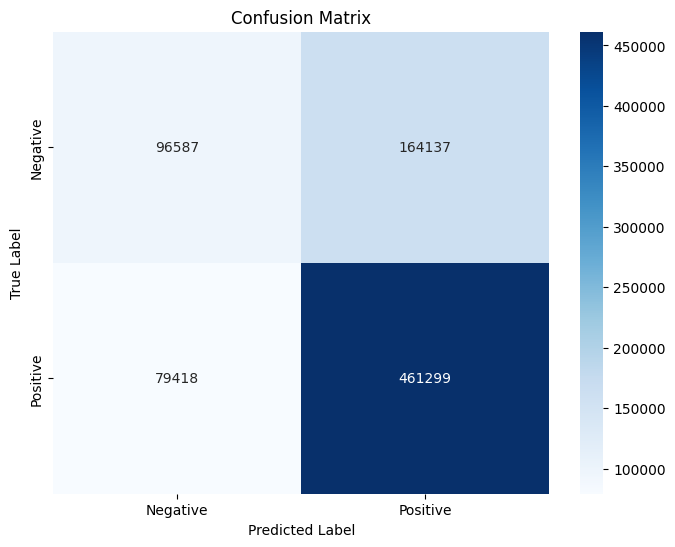

In [20]:
test_labels= df_critiques['Polarité_réelle']
predictions = df_critiques['Text_blob_critique_nettoyé']

# On stock nos données dans un dictionnaire
results = {
    'Accuracy': metrics.accuracy_score(test_labels, predictions),
    'Precision': metrics.precision_score(test_labels, predictions),
    'Recall': metrics.recall_score(test_labels, predictions),
    'F1 Score': metrics.f1_score(test_labels, predictions),
    'Classification Report': metrics.classification_report(test_labels, predictions),
    'Confusion Matrix': metrics.confusion_matrix(test_labels, predictions)
}
    
# Print metriques
print("\nAccuracy:", results['Accuracy'])
print("Precision:", results['Precision'])
print("Recall:", results['Recall'])
print("F1 Score:", results['F1 Score'])
    
# Print classification report
print("\nClassification Report:")
print(results['Classification Report'])


# Display confusion matrix as a heatmap using seaborn
cm = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Commentaire :

In [21]:
df_critiques.groupby('Polarité_réelle').size()


Polarité_réelle
0    260724
1    540717
dtype: int64

In [22]:
# On prépare nos jeux jeux de test et d'entrainement pour le countvectorizer et pour le ML

critique_train, critique_test, polarite_train, polarite_test = train_test_split(df_critiques['Critique_nettoy'], df_critiques['Polarité_réelle'], test_size=0.2, random_state=4)

In [23]:
# CountVectorizer

cv = CountVectorizer()
cv_train_features = cv.fit_transform(critique_train)
cv_test_features = cv.transform(critique_test)

In [26]:
# Rôle de la fonction : Fit + résultat du modèle
# Entrée : Modèle considéré, les 4 sets de test et d'entrainement
# Sortie : les résultats du modèles

def evaluate_model(model, train_features, train_labels, test_features, test_labels):
    
    model.fit(train_features, train_labels)

    # Cross-validation 
    cv_scores = cross_val_score(model, train_features, train_labels, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
    print("Cross-validation Scores:", cv_scores)
    print("Mean CV Accuracy:", np.mean(cv_scores))

    # Predictions
    predictions = model.predict(test_features)

    # On stock nos données dans un dictionnaire
    results = {
        'Accuracy': metrics.accuracy_score(test_labels, predictions),
        'Precision': metrics.precision_score(test_labels, predictions),
        'Recall': metrics.recall_score(test_labels, predictions),
        'F1 Score': metrics.f1_score(test_labels, predictions),
        'Classification Report': metrics.classification_report(test_labels, predictions),
        'Confusion Matrix': metrics.confusion_matrix(test_labels, predictions)
    }
    
    # Print metriques
    print("\nAccuracy:", results['Accuracy'])
    print("Precision:", results['Precision'])
    print("Recall:", results['Recall'])
    print("F1 Score:", results['F1 Score'])
    
    # Print classification report
    print("\nClassification Report:")
    print(results['Classification Report'])


    # Display confusion matrix as a heatmap using seaborn
    cm = confusion_matrix(test_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    return results


In [28]:
%%time

# Define logistic regression model
model_lr = LogisticRegression(max_iter=100000)

# Hyperparameter tuning using GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(model_lr, param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
grid_search.fit(cv_train_features, polarite_train)

# Print best parameters
print("Best Parameters: ", grid_search.best_params_)

best_model = grid_search.best_estimator_

logistic_regression_results = evaluate_model(best_model, cv_train_features, polarite_train, cv_test_features, polarite_test)


KeyboardInterrupt: 

In [15]:
%%time
# Example with Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_results = evaluate_model(random_forest, cv_train_features, polarite_train, cv_test_features, polarite_test)

In [41]:
%%time
# Example with Support Vector Machine
svm = SVC(kernel='linear', C=1)
svm_results = evaluate_model(svm, cv_train_features, polarite_train, cv_test_features, polarite_test)

In [ ]:
%%time
# Example with K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn_results = evaluate_model(knn, cv_train_features, polarite_train, cv_test_features, polarite_test)

Cross-validation Scores: [0.84918623 0.84703387 0.84817905 0.84860017 0.84770335]
Mean CV Accuracy: 0.8481405346329209

Accuracy: 0.8496278596784558
Precision: 0.8920851919799592
Recall: 0.8844499021309599
F1 Score: 0.8882511393719661

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.78      0.77     51981
           1       0.89      0.88      0.89    108308

    accuracy                           0.85    160289
   macro avg       0.83      0.83      0.83    160289
weighted avg       0.85      0.85      0.85    160289



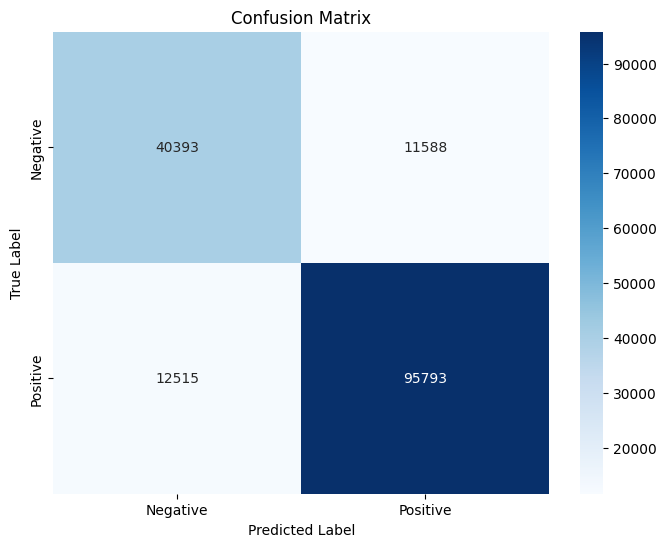

CPU times: user 2.3 s, sys: 773 ms, total: 3.07 s
Wall time: 2.83 s


In [ ]:
%%time
# Naive Bayes on Count Vectors

model_MultinomialNB= naive_bayes.MultinomialNB()
MultinomialNB_results = evaluate_model(model_MultinomialNB, cv_train_features, polarite_train, cv_test_features, polarite_test)

## CamemBERT    

In [12]:
from torch.utils.data import TensorDataset, random_split, \
                            DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertForSequenceClassification, CamembertTokenizer, \
                         AdamW, get_linear_schedule_with_warmup


/home/onyxia/work/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
df_critiques

,id_allocine,Critique,Note_critique_float,new_date,Critique_nettoy,Polarité_réelle,Text_blob_critique_nettoyé
0,239331,"""10.000 days"" est à la base une série créée pa...",0.5,2015-10-05,day bas ser cré eric small réalis film où retr...,-1,-1
1,239331,Les effets spéciaux bas de gamme mettent les a...,1.0,2015-12-12,effet spécial bas gamm mettent acteur situat r...,-1,1
2,239331,"10,000 somnifères. A peine ça commence qu'un g...",1.0,2017-01-10,somnifer a pein ça commenc gar racont lif pass...,-1,1
3,239331,"""10 000 days"" est d'une nullité abyssale. Tout...",0.5,2016-05-24,10 000 day nullit abyssal tout concourt fair s...,-1,1
4,239331,"Beaucoup de parlotes, pas d'action ni d'effets...",1.5,2017-01-01,beaucoup parlot ni spécial histoir moll tout c...,-1,1
...,...,...,...,...,...,...,...
801584,146631,Si vous aimez quand la débilité camoufle la pe...,2.5,2016-09-03,si aim quand débil camoufl pertinent premi zoo...,0,1
801585,146631,"La sauce ne prend malheureusement pas. ""Zoolan...",2.0,2016-05-17,sauc prend malheur zooland devenu cult temp su...,-1,1
801586,146631,la demi étoiles et pour le casting avec des ac...,0.5,2020-07-15,dem étoil casting acteur fou film a humour tre...,-1,0
801587,146631,Pas aussi mauvais...Pas très Drôle mais amusan...,2.5,2016-03-21,auss mauv tres drôl amus bien film temp temp s...,0,1


In [13]:
critique = df_critiques['Critique'].values.tolist()
polarite = df_critiques['Polarité_réelle'].values.tolist()

TOKENIZER = CamembertTokenizer.from_pretrained(
    'camembert-base',
    do_lower_case=True)

sentencepiece.bpe.model: 100%|██████████| 811k/811k [00:00<00:00, 3.10MB/s]
tokenizer.json: 100%|██████████| 1.40M/1.40M [00:00<00:00, 3.23MB/s]
config.json: 100%|██████████| 508/508 [00:00<00:00, 1.10MB/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
